In [2]:
pip install tensorflow

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from keras.datasets import imdb
from keras.layers import GRU, LSTM, CuDNNGRU, CuDNNLSTM, Activation, Input, concatenate, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

In [4]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline

In [5]:
df = pd.DataFrame()
for i in range(1,128):
    temp = pd.read_csv('batch' + str(i)+'.csv')
    df = pd.concat([df,temp])

In [6]:
df

,Unnamed: 0,LocalTime,Power(MW),latitute,longitude,UPV/DPV,Capacity,State,Temp,Prcp
0,0,01/01/06,3.603819,30.45,-88.25,UPV,70MW,al,12.27,0.01
1,1,01/02/06,9.951389,30.45,-88.25,UPV,70MW,al,15.08,10.32
2,2,01/03/06,12.944792,30.45,-88.25,UPV,70MW,al,16.54,1.60
3,3,01/04/06,12.747222,30.45,-88.25,UPV,70MW,al,9.84,0.00
4,4,01/05/06,13.602778,30.45,-88.25,UPV,70MW,al,12.01,0.00
...,...,...,...,...,...,...,...,...,...,...
360,360,12/27/06,2.811111,42.95,-71.75,DPV,27MW,nh,0.87,1.99
361,361,12/28/06,3.009375,42.95,-71.75,DPV,27MW,nh,-2.74,0.24
362,362,12/29/06,0.239236,42.95,-71.75,DPV,27MW,nh,-3.44,0.21
363,363,12/30/06,2.953819,42.95,-71.75,DPV,27MW,nh,-7.11,0.04


In [7]:
df = df.reset_index()

In [8]:
final = df.drop(columns = ['index','Unnamed: 0'])

In [9]:
final

,LocalTime,Power(MW),latitute,longitude,UPV/DPV,Capacity,State,Temp,Prcp
0,01/01/06,3.603819,30.45,-88.25,UPV,70MW,al,12.27,0.01
1,01/02/06,9.951389,30.45,-88.25,UPV,70MW,al,15.08,10.32
2,01/03/06,12.944792,30.45,-88.25,UPV,70MW,al,16.54,1.60
3,01/04/06,12.747222,30.45,-88.25,UPV,70MW,al,9.84,0.00
4,01/05/06,13.602778,30.45,-88.25,UPV,70MW,al,12.01,0.00
...,...,...,...,...,...,...,...,...,...
46354,12/27/06,2.811111,42.95,-71.75,DPV,27MW,nh,0.87,1.99
46355,12/28/06,3.009375,42.95,-71.75,DPV,27MW,nh,-2.74,0.24
46356,12/29/06,0.239236,42.95,-71.75,DPV,27MW,nh,-3.44,0.21
46357,12/30/06,2.953819,42.95,-71.75,DPV,27MW,nh,-7.11,0.04


In [10]:
final = final[final['LocalTime'].notna()]

In [11]:
final

,LocalTime,Power(MW),latitute,longitude,UPV/DPV,Capacity,State,Temp,Prcp
0,01/01/06,3.603819,30.45,-88.25,UPV,70MW,al,12.27,0.01
1,01/02/06,9.951389,30.45,-88.25,UPV,70MW,al,15.08,10.32
2,01/03/06,12.944792,30.45,-88.25,UPV,70MW,al,16.54,1.60
3,01/04/06,12.747222,30.45,-88.25,UPV,70MW,al,9.84,0.00
4,01/05/06,13.602778,30.45,-88.25,UPV,70MW,al,12.01,0.00
...,...,...,...,...,...,...,...,...,...
46353,12/26/06,1.597222,42.95,-71.75,DPV,27MW,nh,1.47,10.95
46354,12/27/06,2.811111,42.95,-71.75,DPV,27MW,nh,0.87,1.99
46355,12/28/06,3.009375,42.95,-71.75,DPV,27MW,nh,-2.74,0.24
46356,12/29/06,0.239236,42.95,-71.75,DPV,27MW,nh,-3.44,0.21


In [12]:
data_to_use = final['Power(MW)'].values

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1,1))

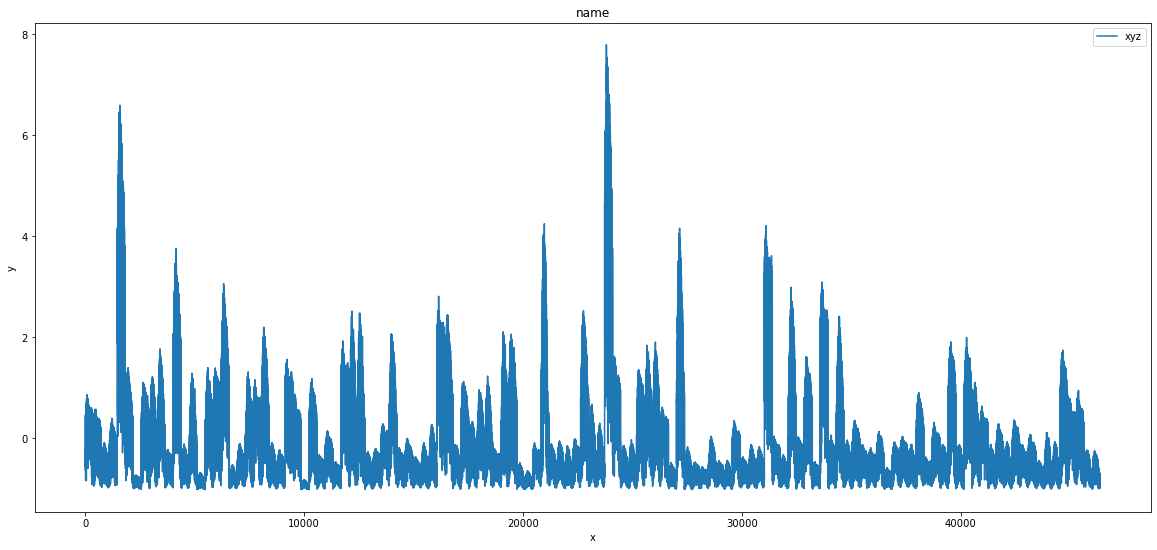

In [14]:
plt.figure(figsize = (20,9),frameon = False, facecolor = 'red', edgecolor = 'blue')
plt.title('name')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(scaled_data, label = 'xyz')
plt.legend()
plt.show()


In [15]:
def window_data(data, window_size):
    x = []
    y = []
    
    i = 0
    while (i + window_size)<= len(data)-1:
        x.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i +=1
    assert len(x)==len(y)
    return x,y
x,y = window_data(scaled_data, 364)

In [16]:
import numpy as np
x_train = np.array(x[:36501])
y_train = np.array(y[:36501])

x_test = np.array(x[36501:])
y_test = np.array(y[36501:])

In [17]:
batch_size = 100
window_size = 364
hidden_layer = 256
clip_margin = 4
learning_rate = .001
epochs = 200

In [18]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [19]:
inputs = tf.compat.v1.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.compat.v1.placeholder(tf.float32, [batch_size, 1])

In [20]:
weights_input_gate = tf.Variable(tf.truncated_normal([1,hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget =  tf.Variable(tf.zeros([hidden_layer]))

In [21]:
weights_output_gate = tf.Variable(tf.truncated_normal([1,hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output =  tf.Variable(tf.zeros([hidden_layer]))

In [22]:
weights_memory_cell = tf.Variable(tf.truncated_normal([1,hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell =  tf.Variable(tf.zeros([hidden_layer]))

In [23]:
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

In [24]:
def LSTM_cell(input, output, state):
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    state = state * forget_gate * input_gate * memory_cell
    output = output_gate * tf.tanh(state)
    return state, output

In [25]:
outputs = []
for i in range(batch_size):
    
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    for j in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][j], (-1, 1)), batch_state, batch_output)
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_2912:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_5825:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_8738:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_11651:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_14564:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_17477:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_20390:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_23303:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_26216:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_29129:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_32042:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_34955:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_37868:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_40781:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_43694:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_46607:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_49520:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_52433:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor '

In [26]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1,1)), outputs[i]))
loss = tf.reduce_mean(losses)

In [ ]:
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(x_train):
        x_batch = x_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:x_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))